In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
from numpy.linalg import solve

In [19]:
ndx = 5
dx = 400
dy = 650
h = 60
# Static rock properties
phi = 0.27
kx = 270
ky = 270
Vb = dx*dy*h
cp = 0
# fluid properties
mu = 1
rho = 62.4
FVF = 1
betha_c = 0.001127
cf = 7e-6
alpha_c = 5.614583

In [4]:
# delta time (timestep)
dt = 0.001
# Number of time steps
ndt = 500
# Length
L = 1200
# Number of grids == number of nodes-1
ndx = 3
# boundary conditions pressure (numpy array with a length of 2)
bc_pressure = np.array([3750, 1250])


### Explicit

In [5]:
# Function to solve pressure equation for 1D
def pressure_equation_explicit(bc_pressure, dt, ndt, L, ndx):
    dx = L/ndx
    pressure = np.zeros(shape=[ndx+1, ndt], dtype=np.float64)
    pressure[0,:] = bc_pressure[0].copy()
    pressure[-1,:] = bc_pressure[1].copy()
    dt_dx2 = dt/(dx*dx)
    for t in range(ndt-1):
        pressure[1:-1, t+1] = pressure[1:-1, t] + dt_dx2*(pressure[:-2, t] + pressure[2:, t] - 2*pressure[1:-1, t])
    return pressure

### Implicit

In [6]:
def pressure_equation_implicit(bc_pressure, dt, ndt, L, ndx=10):
    pressure = np.zeros(shape=[ndx+1, ndt])
    pressure[0,:] = bc_pressure[0].copy()
    pressure[-1,:] = bc_pressure[1].copy()
    for time in np.arange(ndt-1):
        A = np.zeros([ndx-1, ndx-1])
        b = np.zeros(ndx-1) # Unnecessary; dimensions defined by pressure length - 2
        dx = L/ndx
        a = -(2+dx*dx/dt)
        for i in range(ndx-2):
            A[i+1, i] = 1
            A[i, i+1] = 1
            A[i, i] = a
            if i == ndx-3:
                A[i+1,i+1] = a
        b = -(dx*dx/dt)*pressure[1:-1, time]
        b[0] = -(dx*dx/dt)*pressure[1, time] - pressure[0, time]
        b[-1] = -(dx*dx/dt)*pressure[-2, time] - pressure[-1, time]
        pressure[1:-1, time+1] = np.linalg.solve(A, b)
    return pressure

In [9]:
ndx = 3
dt = 0.001
ndt = 100
p_ex = pressure_equation_explicit(bc_pressure, dt, ndt, L, ndx=ndx)

p_im = pressure_equation_implicit(bc_pressure, dt, ndt, L, ndx=ndx)

In [16]:
r2_time = np.array([r2_score(p_im[:, t], p_ex[:, t]) for t in np.arange(ndt)])

Text(0.5, 1.0, 'Time : 0.05 s')

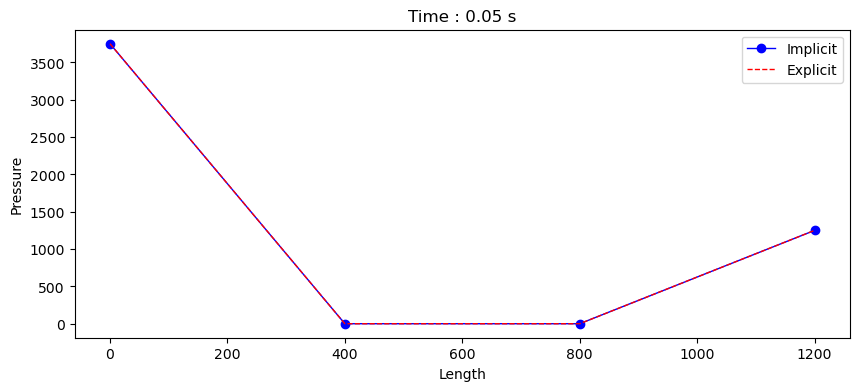

In [10]:
timestep = 50
plt.figure(figsize=(10,4))
plt.ylabel('Pressure')
plt.xlabel('Length')
plt.plot(np.linspace(0, L, ndx+1), p_im[:, timestep], 'bo-', linewidth=1)
plt.plot(np.linspace(0, L, ndx+1), p_ex[:, timestep], 'r--', linewidth=1)
plt.legend(['Implicit', 'Explicit'])
plt.title(f"Time : {timestep*dt} s")